# Predicting Diabetic Patient Readmissions with Machine Learning

<p><a name="sections"></a></p>


# Table of Contents

- <a href="#intro">Introduction</a><br>
 - <a href="#motivation">Motivation</a><br>
 - <a href="#dataset">Dataset</a><br>
 - <a href="#process">Process</a><br>
 - <a href="#eval">Model Evaluation</a><br>
 
- <a href="#importshelp">Imports and Helper Functions</a><br>
 - <a href="#modules">Importing Libraries</a><br>
 - <a href="#helper">Helper Functions</a><br>
- <a href="#processing">Data Processing</a><br>
 - <a href="#missing">Missing Values</a><br>
 - <a href="#featprocessing">Feature Processing</a><br>
 - <a href="#numcat">Preprocessing Numeric and Categorical Features</a><br>
 - <a href="#encodescale">Encoding/Scaling</a><br>
 - <a href="#upsampling">Addressing Imbalanced Dataset</a><br>
- <a href="#base">Base Machine Learning Algorithms</a><br>
 - <a href="#dt">Decision Tree Classifier</a><br>
 - <a href="#lr">Logistic Regression Classifier</a><br>
 - <a href="#rf">Random Forest Classifier</a><br>
 - <a href="#xgb">XGBoost Classifier</a><br>
- <a href="#optimized">Optimized Machine Learning Algorithms</a><br>
 - <a href="#dtcv">Decision Tree Hyperparameter Tuning</a><br>
 - <a href="#lrcv">Logistic Regression Hyperparameter Tuning</a><br>
 - <a href="#lrbag">Logistic Regression Bagging</a><br>
 - <a href="#rfcv">Random Forest Hyperparameter Tuning</a><br>
 - <a href="#xgbcv">XGBoost Hyperparameter Tuning</a><br>
 - <a href="#ensemble">Stacking Multiple Estimators</a><br> 
- <a href="#conclusion">Conclusion</a><br>

<p><a name="intro"></a></p>

# Introduction

The objective of this exercise is to develop machine learnings models that will help hospitals reduce their readmission rates among diabetic patients.

<p><a name="motivation"></a></p>

## Motivation

In an effort to improve the quality of hospital care in the United States, the Affordable Care Act created the Hospital Readmission Reduction Program to improve the quality of healthcare for Americans by tying hospital payments to patient readmission rates. In other words, this program seeks to incentivize hospitals to provide high quality healthcare by financially penalizing hospitals with higher readmission rates.                

This project endeavors to aid in achieving the goals set forth by the Hospital Readmission Reduction Program by positively impacting two key stakeholders in the American healthcare system: 

1. **Patients:** Correctly identifying patients who are likely to be readmitted and will enable hospitals to take preventative measures so that patients will receive the best possible healthcare and avoid adverse health consequences
2. **Hospitals:** Tying lower readmission rates to higher hospital revenues will foster efficiency from a financial perspective, allowing hospitals to reallocate a larger pool of resources to important expenses such as personal protective equipment

In short, lower readmission rates lead to better health for patients and better fiscal health for hospitals.


<p><a name="dataset"></a></p>

## Dataset

The dataset being analyzed in this project was procured from over 10 years (1999-2008) of clinical care in 130 hospitals for the purposes of analyzing the impact of HbA1c (blood sugar level) on hospital readmissions. It is suitable for this project of developing a predictive model for hospital readmissions because it contains over 50 features with each instance representing patient and hospital outcomes (whether they were readmitted to the hospital).  

To qualify as an instance in this dataset, each observation has met the following criteria: 
1. It is an inpatient encounter (a hospital admission)
2. It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis
3. The length of stay was at least 1 day and at most 14 days
4. Laboratory tests were performed during the encounter
5. Medications were administered during the encounter


**Citation**:
Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.


<p><a name="process"></a></p>

## Process

The process for this project entails the training of Decision Tree, Logistic Regression, Random Forest and XGBoost algorithms. The models will then be evaluated on the AUC (Area under (ROC) Curve), which serves as a measure of model performance across all possible classification thresholds. After plotting and determining each model's AUC, feature importances will be plotted for each model, whenever possible, to discern which factors are most likely to contribute towards a patient's readmission. 

Once each of the algorithms are evaluated at a base level (default parameters), we will try to optimize each algorithm through hyperparameter and other machine learning techniques (bootstrap aggregating and stacking) to see if more robust models can be created.

The basic outline of what is described above can be summarized as follows: 

1. Data Processing
2. Training Base Machine Learning Algorithms
3. Evaluating Base Machine Learning Algorithms (AUC / Feature Importance)
4. Hyperparameter Tuning with GridSearchCV + Other Machine Learning Techniques (Bagging / Stacking)
5. Evaluating Optimized Machine Learning Algorithms (AUC / Feature Importance)
6. Conclusion


<p><a name="eval"></a></p>

## Model Evaluation

In order to best measure how well our models predict hospital readmissions, it is important to understand the ROC Curve and AUC (Area Under the Curve). 

An **ROC (receiver operating characteristic) curve** visualizes the performance of a classification model across all classification thresholds by plotting the true postive rate (true positives / all positives) and the false positive rate (false positives / all negatives) as seen below:

<img src="https://developers.google.com/machine-learning/crash-course/images/ROCCurve.svg" width="400" height="100">
*Source: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc*

**AUC (area under the ROC curve)** measures the 2-dimensional area underneath the ROC curve and ranges in value from 0 to 1 as shown below. 

<img src="https://developers.google.com/machine-learning/crash-course/images/AUC.svg" width="400" height="100">
*Source: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc*

In an extreme example, a perfect classifier would maximize true positives while minimizing false positives, thus bringing the ROC Curve all the way to the top left (simultaneously making the AUC cover the entire plot). Alternatively, a model that is always wrong would bring the ROC curve all the way to the bottom right, thus minimizing the AUC.

<p><a name="importshelp"></a></p>

# Imports and Helper Functions

<p><a name="modules"></a></p>

## Importing Libraries

In [1]:
# pandas and numpy for data analysis
import pandas as pd 
import numpy as np 

# data visualization packages 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
pd.set_option('max_columns', None)

# SMOTE package to address imbalanced classes 
from imblearn.over_sampling import SMOTE 

# machine learning packages (sklearn + xgboost)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

<p><a name="helper"></a></p>

## Helper Functions

In [2]:
# Plot Confusion Matrix
def plot_cm(estimator,title):
    '''Plots confusion matrix
    
    Plots confusion matrix
    
    Args:
        model: 
            Trained (fitted) ML algorithm
        title:
            Machine algorithm that corresponds with the estimator to insert into title of plot
    Returns: 
        Plot of confusion matrix for unseen test data set
        
    '''        
    
    from sklearn.metrics import plot_confusion_matrix
    
    plt.figure(figsize=(10,8))
    plot_confusion_matrix(estimator, X=X_test, y_true=y_test, 
                          display_labels=['Not Readmitted', 'Readmitted'], 
                          cmap='Blues', values_format='d')
    plt.title(str(title)+' '+'Confusion Matrix')

In [3]:
# Plot ROC Curve
def plot_roc_curve(model, X_test, y_test, title = "ROC Curve"):
    '''Plots roc curve
    
    Plots ROC curve 
    
    Args:
        model: 
            Machine learning algorithm to evaluate
        X_test: 
            Test data to evaluate
        y_test:
            Test outputs 
        title:
            Title for plot            
    Returns: 
        An ROC curving allowing for comparison of false positive vs true postive rates
        
    '''    
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (10,8))
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = "AUC = %0.2f"%roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()

In [4]:
# Plot Feature Importance
def plot_feature_importance(values, names, model_name, n_features=10):
    '''Plots feature importances 
    
    Plots top important features for a given model
    
    Args:
        values: 
            Feature importance values for a given model
        names: 
            Feature names from training data set
        n_features: 
            Number of features to show - default is 10
            
    Returns: 
        A bar plot showing the top n_features. 
        
    '''
    # make arrays for feature importance values and names 
    feature_importance = np.array(values)
    feature_names = np.array(names)
    
    # create DataFrame and sort by feature importance
    data = {'Feature':feature_names, 'Feature Importance':feature_importance}
    fidf = pd.DataFrame(data)
    fidf = fidf.sort_values('Feature Importance', ascending=False).head(n_features)
    
    # plot figure
    plt.figure(figsize = (10,8))
    sns.barplot(x=fidf['Feature Importance'], y=fidf['Feature'], palette='coolwarm')
    plt.title(model_name + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    
    from IPython.core.display import HTML
    HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)

<p><a name="processing"></a></p>

# Data Processing

In [5]:
df = pd.read_csv('./data/diabetic_data.csv', na_values='?')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


<p><a name="missing"></a></p>

## Missing Values


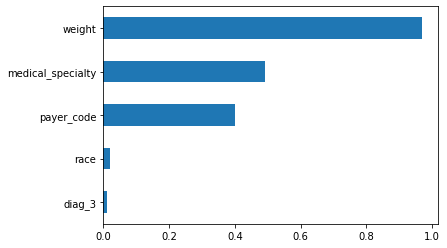

In [6]:
missing = round((df.isna().sum()/len(df)),2).sort_values(ascending = True)
missing = missing[missing > 0]
missing.plot(kind='barh')

In [7]:
missing

diag_3               0.01
race                 0.02
payer_code           0.40
medical_specialty    0.49
weight               0.97
dtype: float64

The top three features with missing values are weight, medical_specialty, and payer_code. To address missingness, we will either drop or impute these features as shown below: 

In [8]:
# dropping features
drop_cols = ['encounter_id', 'weight',
             'admission_type_id',
             'discharge_disposition_id',
             'admission_source_id', 'diag_1',
             'diag_2','diag_3', 'examide','citoglipton'] # either no variance or too not enough info provided
df.drop(drop_cols, axis=1, inplace = True)

# drop duplicate patient encounters
df.drop_duplicates('patient_nbr', keep = 'first')
df.drop('patient_nbr', axis = 1, inplace = True)

In [9]:
# impute payer code with mode
df.loc[df['payer_code'].isnull(), 'payer_code'] = df['payer_code'].value_counts().index[0]

In [10]:
# drop medical specialty column
print('Number of unique medical specialty',str(len(df['medical_specialty'].unique())))
df.drop('medical_specialty', axis=1, inplace=True)

Number of unique medical specialty 73


In [11]:
# checking for missing values
df.dropna(axis=0, inplace=True)
print('Number of missing values: ',str((df.isna().sum() > 0).sum()))

Number of missing values:  0


<p><a name="featprocessing"></a></p>

## Feature Processing

After addressing missing values, furthering feature processing must occur. Generally speaking, machine learning algorithms are more compatible with numeric values. As a result, some data manipulation must occur for certain categorical features for compatibility purposes.

In [12]:
# gender
df = df[df['gender']!='Unknown/Invalid']

In [13]:
# quantify age categories in 10 buckets

df['age'] = df['age'].map({'[10-20)':1, '[20-30)':2, '[30-40)':3, '[40-50)':4, '[50-60)':5, '[60-70)':6,
                           '[70-80)':7, '[80-90)':8, '[90-100)':9, '[0-10)':0}) 

In [14]:
# quanitify glucose measurement readings

df['max_glu_serum'] = df['max_glu_serum'].map({'None':0, 'Norm':100, '>200':200, '>300':300})

In [14]:
# quantify A1C measurement

df['A1Cresult']= df.A1Cresult.map({'None':0,'Norm':3,'>7':7,'>8':8})

In [15]:
# quantify change in medications

medication = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for med in medication:
    df[med] = df[med].map({'Up':1, 'Down':1, 'Steady':1, 'No':0})

In [16]:
# encode change in medicine

df['change'] = df['change'].map({'Ch':1,'No':0})

In [17]:
# encode whether patient is on medications

df['diabetesMed'] = df.diabetesMed.map({'Yes':1, 'No':0})

In [18]:
# encode output variable

df['readmitted'] = df.readmitted.map({'NO':0, '>30':0, '<30':1})

<p><a name="numcat"></a></p>

## Preprocessing Numeric and Categorical Features

In [19]:
# seperate numeric and categorical features for standard scaling and encoding

categorical = []
continuous = []

for col in df.columns:
    if df[col].dtype == 'O':
        categorical.append(col)
    elif col != 'readmitted':
        continuous.append(col)
        
print(categorical, end = '\n')
print(continuous)


['race', 'gender', 'age', 'payer_code', 'diag_3', 'max_glu_serum']
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


<p><a name="encodescale"></a></p>

## Encoding / Scaling

In [20]:
X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [21]:
X = pd.get_dummies(X, columns = categorical)

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

<p><a name="upsampling"></a></p>

## Addressing Imbalanced Dataset



One issue that is noticed when examining the output variable is that the dataset is heavily imbalanced towards the majority class (not readmitted). If we do not address this issue, our models will have poor predictive power for the minority (readmitted) class. 

To remedy this problem, we can implement the **Synthetic Minority Oversampling Technique (SMOTE)** to upsample the minority class in our training data set.   

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, stratify = y, random_state = 42)

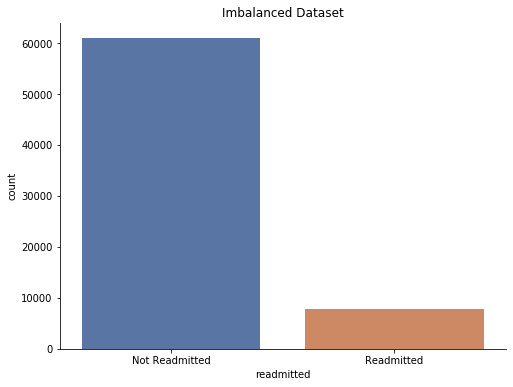

In [47]:
plt.figure(figsize=(8,6))
sns.countplot(y_train, palette='deep')
sns.despine()
plt.title('Imbalanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

In [35]:
# SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

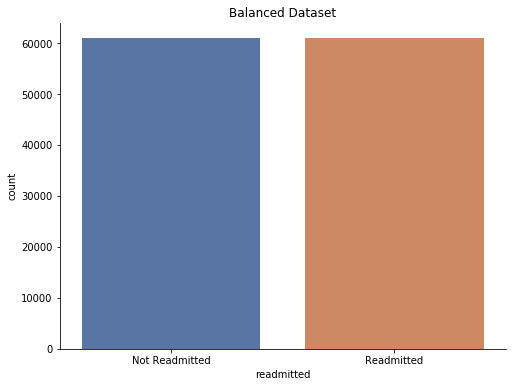

In [49]:
plt.figure(figsize=(8,6))
sns.countplot(y_train_res, palette='deep')
sns.despine()
plt.title('Balanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

<p><a name="base"></a></p>

# Base Machine Learning Algorithms

Now that the data has been prepared, the next step is to train our machine learning models and evaluate their performance (AUC) to establish a baseline upon which we can improve by leveraging hyperparameter tuning and other machine learning techniques. 


<p><a name="dt"></a></p>

## Decision Tree Classifier



In [28]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

<Figure size 720x576 with 0 Axes>

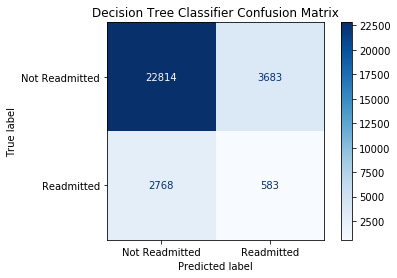

In [83]:
plot_cm(dt_clf, "Decision Tree Classifier")

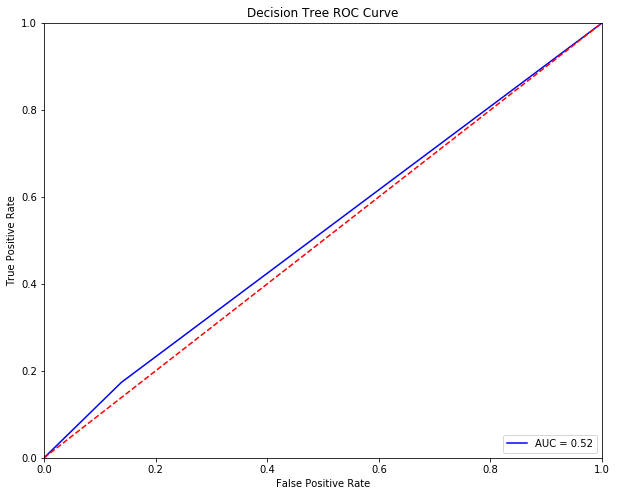

In [30]:
plot_roc_curve(dt_clf, X_test, y_test, "Decision Tree ROC Curve")

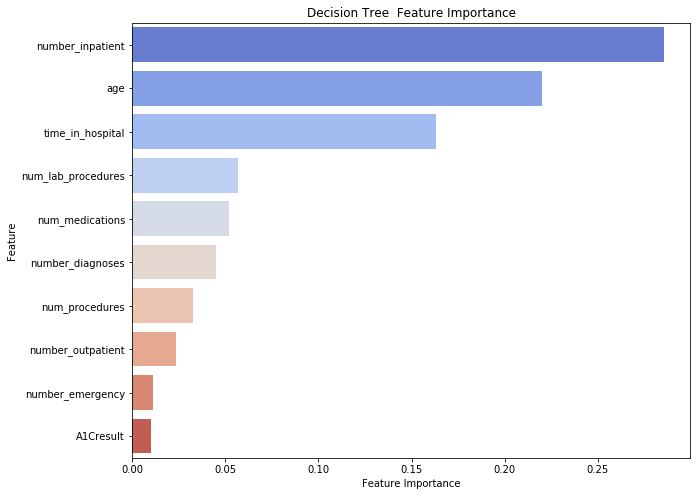

In [90]:
plot_feature_importance(dt_clf.feature_importances_, X_train_res.columns, "Decision Tree ")

#### Decision Tree Classifier Evaluation

**AUC: 0.52**

**Important Features:**
1. Number Inpatient
2. Age 
3. Time in Hospital
4. Number of Lab Procedures
5. Number of Medications

<p><a name="lr"></a></p>

## Logistic Regression Classifier



In [32]:
logmodel = LogisticRegression()
logmodel.fit(X_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<Figure size 720x576 with 0 Axes>

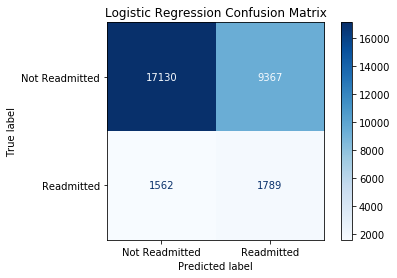

In [33]:
plot_cm(logmodel, 'Logistic Regression')

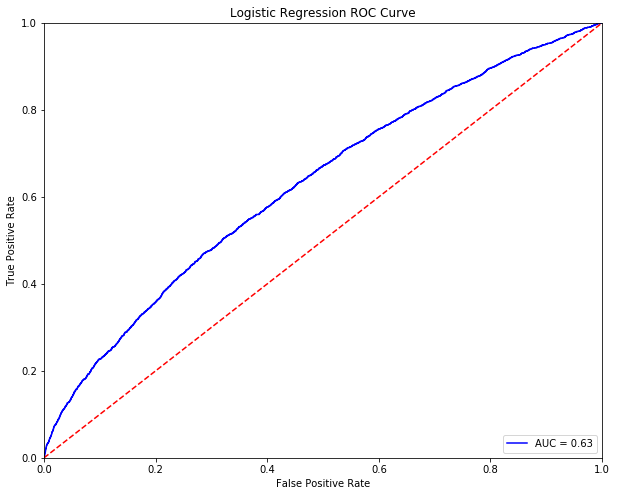

In [34]:
plot_roc_curve(logmodel, X_test, y_test, 'Logistic Regression ROC Curve')

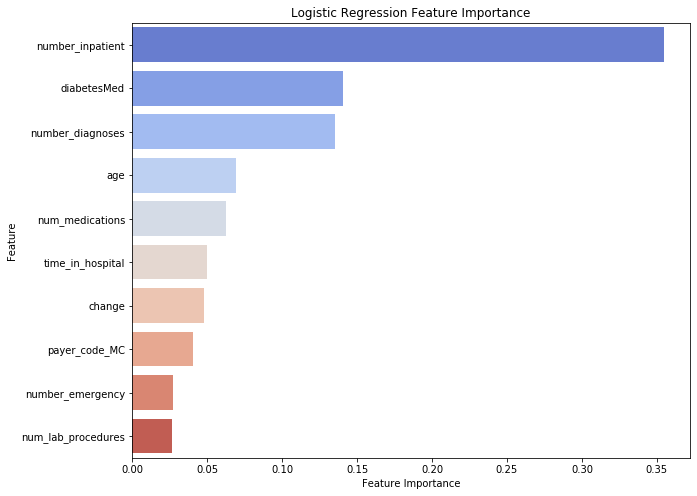

In [35]:
plot_feature_importance(logmodel.coef_.reshape(logmodel.coef_.shape[1],), 
                        X_train_res.columns, 'Logistic Regression')

#### Logistic Regression Classifier Evaluation 

**AUC: 0.63**

**Important Features:**
1. Number Inpatient
2. Diabetes Medication  
3. Number of Diagnoses
4. Age
5. Number of Medications

<p><a name="rf"></a></p>

## Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs = -1)

rf_clf.fit(X_train_res, y_train_res)
rf_preds = rf_clf.predict(X_test)

<Figure size 720x576 with 0 Axes>

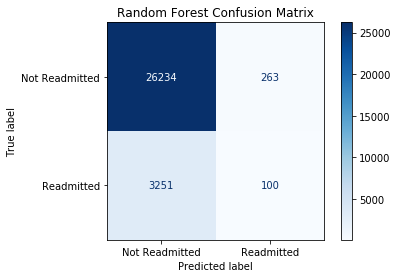

In [37]:
plot_cm(rf_clf, 'Random Forest')

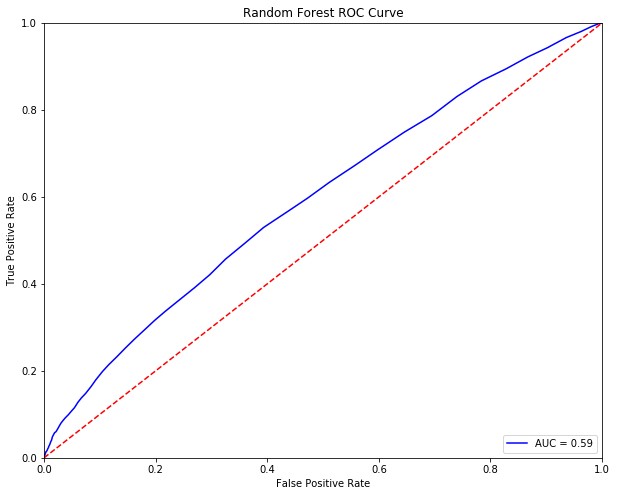

In [38]:
plot_roc_curve(rf_clf, X_test, y_test, title = "Random Forest ROC Curve")

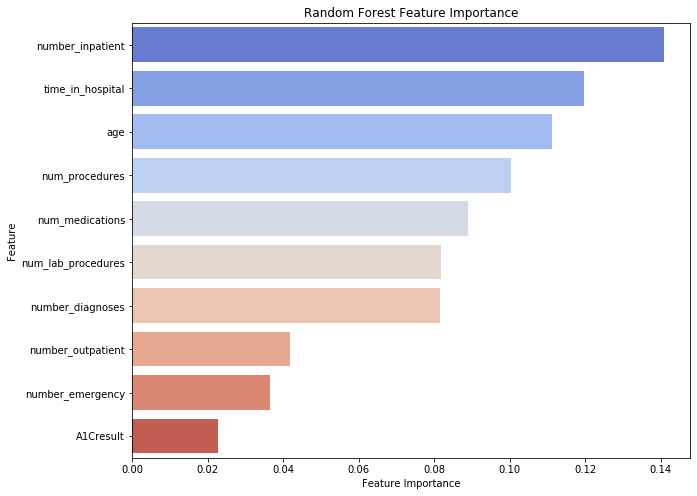

In [39]:
plot_feature_importance(rf_clf.feature_importances_, X_train_res.columns, 'Random Forest')

#### Random Forest Classifier Evaluation 

**AUC: 0.59**

**Important Features:**
1. Number Inpatient
2. Time in Hospital
3. Age
4. Number of Procedures
5. Number of Medications

<p><a name="xgb"></a></p>

## XGBoost Classifier

In [40]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed = 42)
xgb_clf.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

<Figure size 720x576 with 0 Axes>

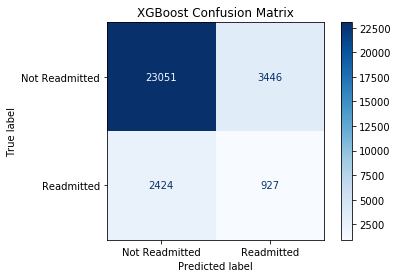

In [41]:
plot_cm(xgb_clf, "XGBoost")

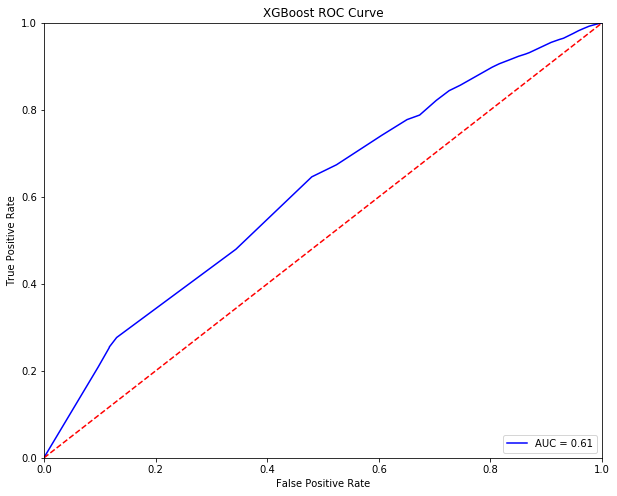

In [42]:
plot_roc_curve(xgb_clf, X_test, y_test,  title="XGBoost ROC Curve")

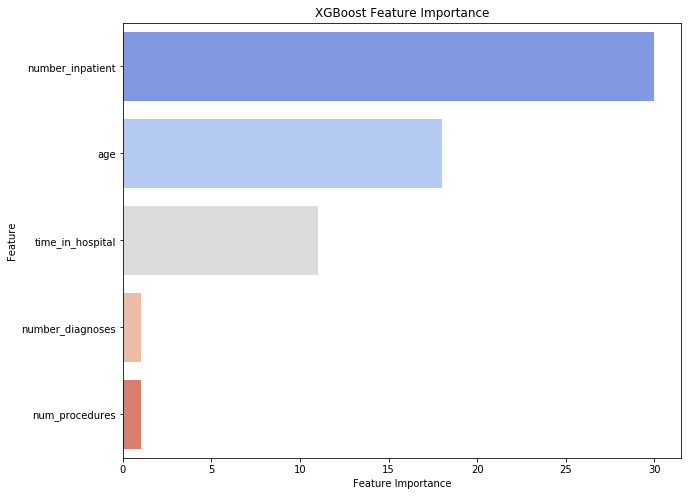

In [43]:
feature_important = xgb_clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

xgb_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

plot_feature_importance(xgb_df.score, xgb_df.index, "XGBoost")

#### XGBoost Classifier Evaluation 

**AUC: 0.61**

**Important Features:**
1. Number Inpatient
2. Age 
3. Time in Hospital
4. Number of Diagnosis
5. Number of Procedures

<p><a name="optimized"></a></p>

# Optimized Machine Learning Algorithms

With an idea of baseline model performance in mind, the next step will be to tune machine learning models using hyperparameter tuning. Additionally, the bootstrap aggregation technique will be applied the Logistic Regression classifier to determine whether a significant improvement in performance can occur. Furthermore, all of the refined models will be ensembled to create a voting classifier. 


<p><a name="dtcv"></a></p>

## Decision Tree Hyperparameter Tuning

In [45]:
max_depth = list(range(1,15,2))
max_features = list(range(1,9))
min_samples_leaf = list(range(2,10,2))
criterion = ['gini', 'entropy']


params_dt = {'max_depth':max_depth, 
            'max_features':max_features, 
            'min_samples_leaf':min_samples_leaf,
            'criterion':criterion}

dt = DecisionTreeClassifier()

dt_cv = GridSearchCV(dt, params_dt, cv=5, verbose=1, n_jobs=-1)

dt_cv.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2240 out of 2240 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [46]:
dt_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

<Figure size 720x576 with 0 Axes>

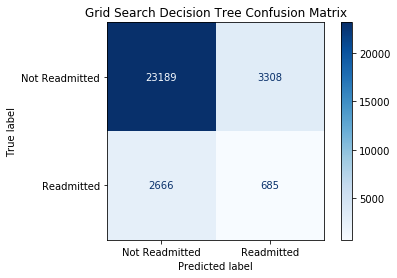

In [47]:
plot_cm(dt_cv.best_estimator_, "Grid Search Decision Tree")

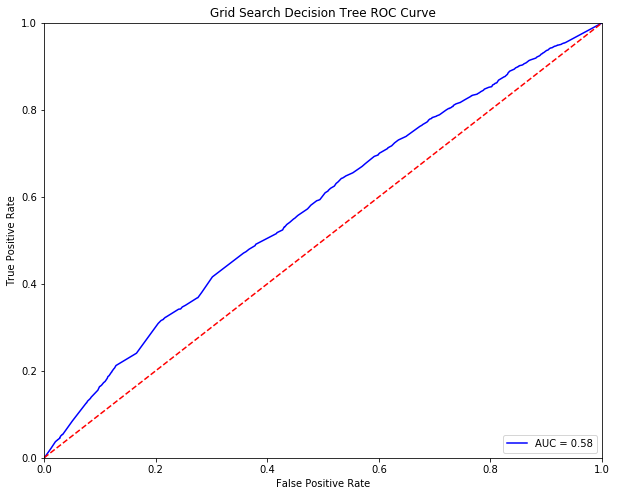

In [48]:
plot_roc_curve(dt_cv.best_estimator_, X_test, y_test, 'Grid Search Decision Tree ROC Curve')

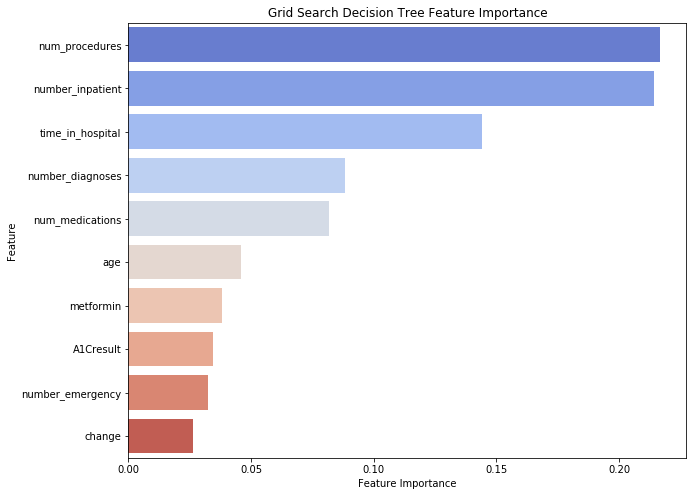

In [49]:
plot_feature_importance(dt_cv.best_estimator_.feature_importances_, 
                        X_train_res.columns, "Grid Search Decision Tree")

#### Tuned Decision Tree Classifier Evaluation 

**AUC: 0.58**

**Important Features:**
1. Number Procedures
2. Number Inpatient 
3. Time in Hospital
4. Number of Diagnoses
5. Number of Medications

<p><a name="lrcv"></a></p>

## Logistic Regression Hyperparameter Tuning

In [50]:
penalty = ['l1', 'l2']
C = np.logspace(0,4,10)

params_lr = {'penalty':penalty, 'C':C}

lr = LogisticRegression()

lr_cv = GridSearchCV(lr, param_grid=params_lr, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')

lr_cv.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             s

In [51]:
lr_cv.best_estimator_

LogisticRegression(C=21.544346900318832, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<Figure size 720x576 with 0 Axes>

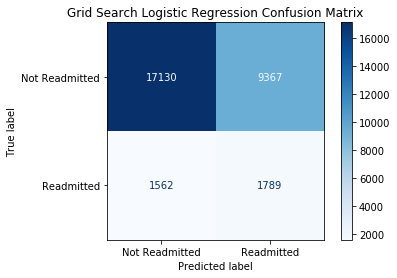

In [52]:
plot_cm(lr_cv, "Grid Search Logistic Regression")

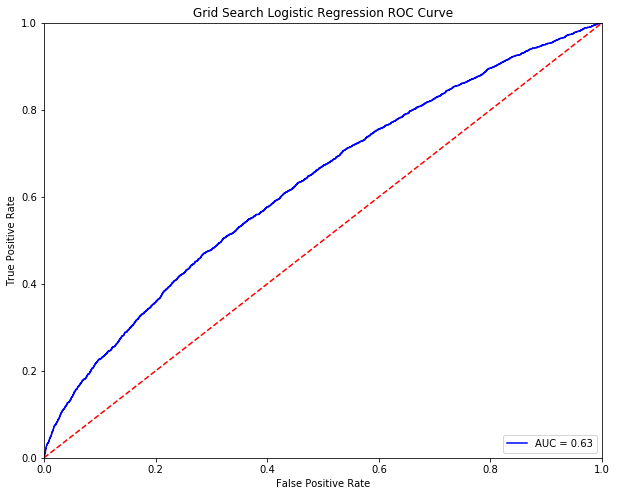

In [53]:
plot_roc_curve(lr_cv, X_test, y_test, "Grid Search Logistic Regression ROC Curve")

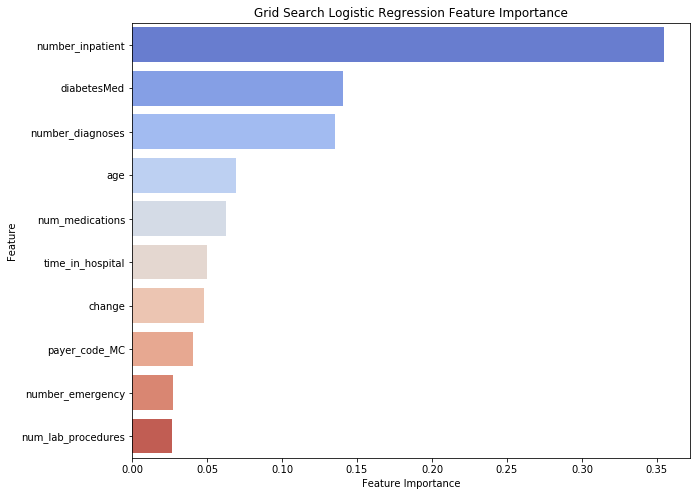

In [54]:
plot_feature_importance(lr_cv.best_estimator_.coef_.reshape(lr_cv.best_estimator_.coef_.shape[1],), X_train_res.columns, 'Grid Search Logistic Regression')

#### Tuned Logistic Regression Classifier Evaluation

**AUC: 0.63**

**Important Features:**
1. Number Inpatient
2. Diabetes Medication
3. Number of Diagnoses
4. Age
5. Number of Medications

<p><a name="lrbag"></a></p>

## Logistic Regression Bagging

In an effort to improve upon hyperparameter tuning, we will implement bootstrap aggregation (bagging). Bagging is a two-step process which as the name would suggest contains these two steps: 
- **Bootstrapping:** a sampling technique where out of *n* samples, *k* samples are chosen **with replacement** for training instances of a machine learning algorithm 
- **Aggregating:** aggregating the predictions of multiple trained instances that are trained on seperate bootstrapped samples 

The hope here is that the bagging will take advantage of ensemble learning with randomly sampled datasets to convert multiple weak learners into a single strong learner, resulting in reduced variance and overfitting.


<img src="https://www.researchgate.net/profile/Agostino_Di_Ciaccio/publication/284156704/figure/fig2/AS:667719821193226@1536208219203/The-Bagging-Bootstrap-Aggregation-scheme.ppm" width="600" height="400">
*Source: https://www.researchgate.net/figure/The-Bagging-Bootstrap-Aggregation-scheme_fig2_284156704*



In [55]:
lr_bagger = BaggingClassifier(lr_cv.best_estimator_, n_jobs=-1)
lr_bagger.fit(X_train_res, y_train_res)

BaggingClassifier(base_estimator=LogisticRegression(C=21.544346900318832,
                                                    class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10,

<Figure size 720x576 with 0 Axes>

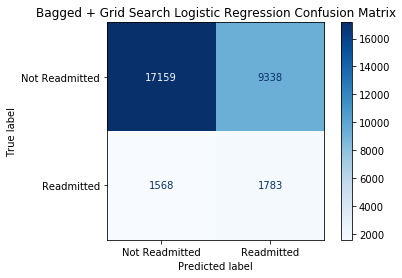

In [56]:
plot_cm(lr_bagger, "Bagged + Grid Search Logistic Regression")

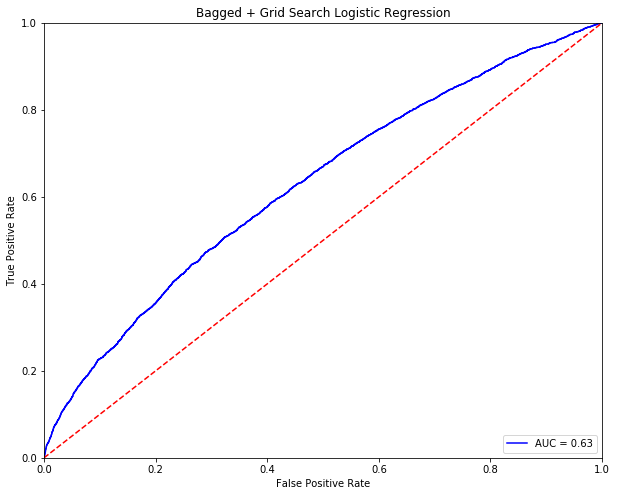

In [57]:
plot_roc_curve(lr_bagger, X_test, y_test, "Bagged + Grid Search Logistic Regression")

#### Tuned Logistic Regression + Bagging Classifier Evaluation 

**AUC: 0.63**

<p><a name="rfcv"></a></p>

## Random Forest Hyperparameter Tuning

In [102]:
max_depth = list(range(10,50,10))
n_estimators = list(range(100,300,50))
max_features = [5,10,15,20]
bootstrap = ['True', 'False']


params_rf = {'max_depth':max_depth, 'n_estimators':n_estimators, 'max_features':max_features, 
             'bootstrap':bootstrap}

rf = RandomForestClassifier()

rf_grid = GridSearchCV(rf, param_grid=params_rf, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 108.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [103]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<Figure size 720x576 with 0 Axes>

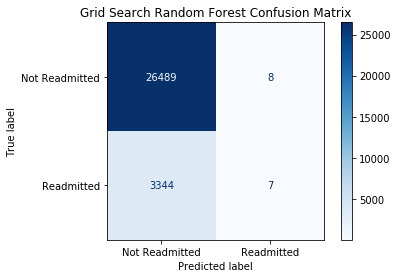

In [104]:
plot_cm(rf_grid.best_estimator_, "Grid Search Random Forest")

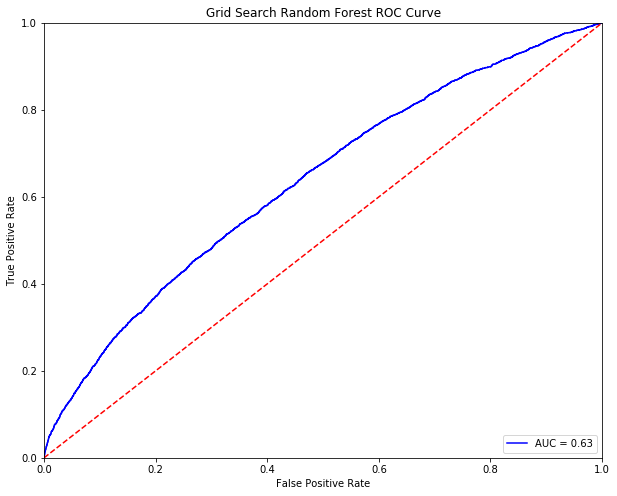

In [92]:
plot_roc_curve(rf_best, X_test, y_test, "Grid Search Random Forest ROC Curve")

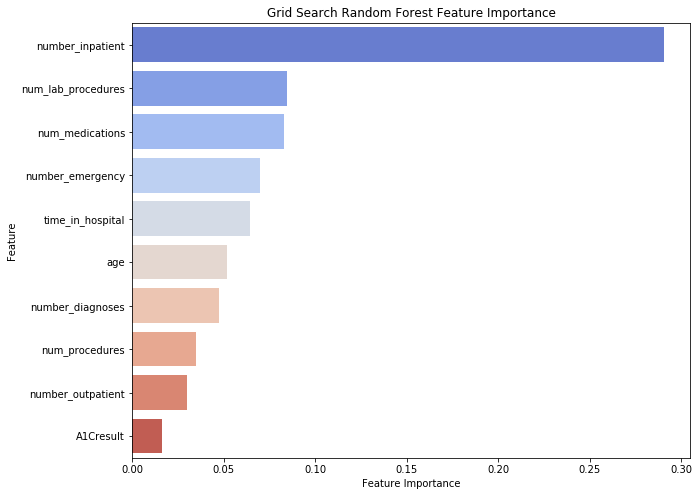

In [106]:
plot_feature_importance(rf_grid.best_estimator_.feature_importances_, X_train_res.columns, 'Grid Search Random Forest')

#### Tuned Random Forest Classifier Evaluation

**AUC: 0.63**

**Important Features:**
1. Number Inpatient
2. Number of Lab Procedures 
3. Number of Medications
4. Number of Emergencies
5. Time in Hospital

In [109]:
import pickle

filename = 'rfbestgrid.sav'

rf_best = rf_grid.best_estimator_

pickle.dump(rf_best, open(filename, 'wb'))

In [91]:
# load model 
import pickle

filename = 'rfbestgrid.sav'

rf_best = pickle.load(open(filename, 'rb'))

<p><a name="xgbcv"></a></p>

## XGBoost Hyperparameter Tuning

In [68]:
eta = np.arange(0.05,0.35,0.05)
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
gamma = [i/10 for i in range(0,5)]

params_xgb = {'eta':eta, 'max_depth':max_depth, 
              'min_child_weight':min_child_weight,
              'gamma':gamma}

xgb_grid = xgb.XGBClassifier()

xgb_clf = GridSearchCV(xgb_grid, param_grid=params_xgb, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)

xgb_clf.fit(X_train_res,y_train_res)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 66.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 209.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 302.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 418.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 565.9min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 571.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': ran

<Figure size 720x576 with 0 Axes>

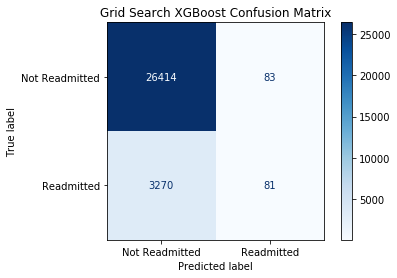

In [73]:
plot_cm(best_xgb, "Grid Search XGBoost")

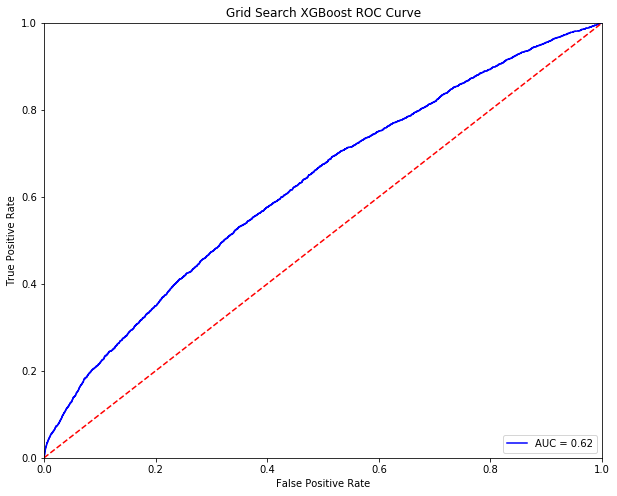

In [74]:
plot_roc_curve(best_xgb, X_test, y_test, "Grid Search XGBoost ROC Curve")

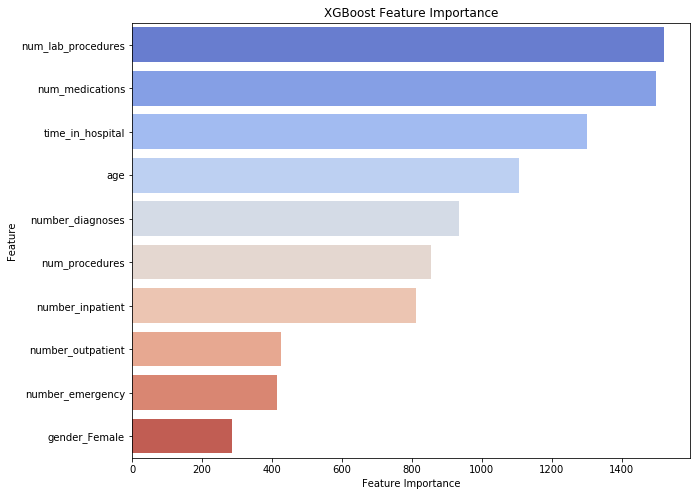

In [75]:
feature_important = best_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

xgb_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

plot_feature_importance(xgb_df.score, xgb_df.index, "XGBoost")

#### Tuned XGBoost Classifier Evaluation 

**AUC: 0.62**

**Important Features:**
1. Number Lab Procedures
2. Number of Medications 
3. Time in Hospital
4. Age
5. Number of Diagnoses

In [71]:
import pickle

best_xgb = xgb_clf.best_estimator_

filename = 'xgb_tuned.sav'

xgb_pickle = best_xgb

pickle.dump(xgb_pickle, open(filename, 'wb'))

xgb_best = pickle.load(open(filename, 'rb'))

<p><a name="ensemble"></a></p>

## Stacking Multiple Estimators

Another machine learning technique that we will utilize is **stacking**, which combines the predictions from two or more base machine learning algorithms. The benefit of stacking is the combined predictive power of a range of robust machine learning algorithms, which should yield predictions that are better than that of any individual algorithm in the ensemble.

<img src="https://www.researchgate.net/profile/Agostino_Di_Ciaccio/publication/284156704/figure/fig1/AS:391744232411157@1470410511879/The-Stacking-scheme.png" width="600" height="400">
*Source: https://www.researchgate.net/figure/The-Stacking-scheme_fig1_284156704*


In [98]:
voter = VotingClassifier(estimators = [('Grid Search Decision Trees',dt_cv),
                                       ('Grid Search Random Forest', rf_best),
                                       ('Grid Search Logistic Regression', lr_cv),
                                       ('Bagged Logistic Regresssion', lr_bagger),
                                       ('Grid Search XGBoost',best_xgb),], voting='soft')

voter.fit(X_train_res, y_train_res)


Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2240 out of 2240 | elapsed:  2.0min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.5s finished


VotingClassifier(estimators=[('Grid Search Decision Trees',
                              GridSearchCV(cv=5, error_score=nan,
                                           estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                            class_weight=None,
                                                                            criterion='gini',
                                                                            max_depth=None,
                                                                            max_features=None,
                                                                            max_leaf_nodes=None,
                                                                            min_impurity_decrease=0.0,
                                                                            min_impurity_split=None,
                                                                            min_samples_leaf=1,
          

<Figure size 720x576 with 0 Axes>

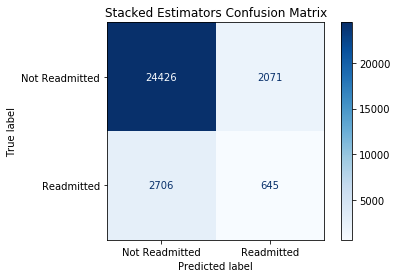

In [99]:
plot_cm(voter, 'Stacked Estimators')

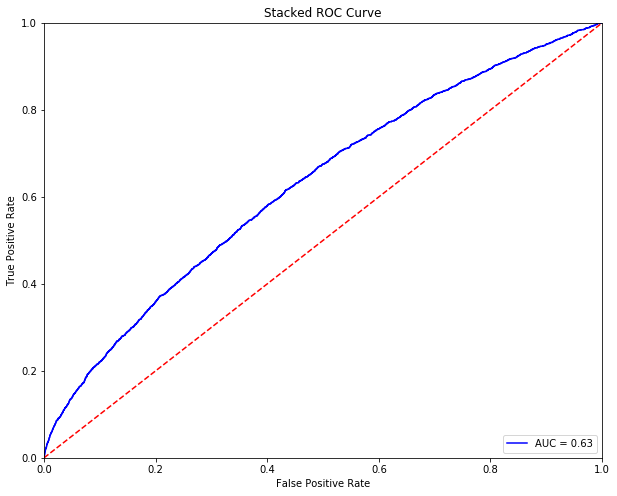

In [100]:
plot_roc_curve(voter, X_test, y_test, 'Stacked ROC Curve')

#### Ensembled Classifier Evaluation 

**AUC: 0.63**

<p><a name="conclusion"></a></p>

# Conclusion

After evaluating the machine learning models that we have trained in this project, we were able to achieve a maximum AUC of **0.63** with the following models: 

- Logistic Regression Classifier 
- Tuned Logistic Regression Classifier 
- Bagged Logistic Regression Classifier 
- Tuned Random Forest Classifier 
- Stacked Classifier 

![title](./summarypic.png)

In terms of preemptive actions that can be taken to reduce patient readmissions, leveraging a few of features deemed as important by our highest performing machine learning models trained in this project can help: 
- **Number of Inpatient visits:** patient intervention teams should pay close attention to frequent visitors to the hospital and appropriate log the reason for each visit to address the root cause of admission
- **Diabetes Medication:** more medications could indicate the potential for more complications - as such key barometers of diabetic health such as a1C (blood sugar levels) should be tracked
- **Number of Diagnoses:** diabetes in conjunction with other health conditions can lead to severely adverse complications - hospitals should ensure that all health conditions are  addressed
- **Age:** patient intervention teams should maintain regular and routine communication with older patients to anticipate any reason for readmission

All things being said, thank you very much for taking the time to go through my analysis of diabetic readmissions. In this notebook we learned how to implement the Decision Tree, Logistic Regression, Random Forest, and XGBoost algorithms. Additionally, we tried to improve the performance of our models through hyperparameter tuning as well as useful machine learning techniques such as bootstrap aggregation and stacking. For models where applicable and interpretable, we leveraged feature importance to discern which aspects of a patient encounter could serve as a flag for hospitals to take action to prevent a patient from being readmitted. 

## Future Work 

In terms of future work, the feature engineering space would be one lever that can be used to improve model performance. The way to best do so, in our view is to conduct some qualitative research to strengthen domain expertise in areas such as medications and other health conditions that could have a big impact on diabetic patients. 

Being able to better contextualize all of these features with domain knowledge, would no doubt, lend towards a better patient experience! 